# **This Looks Like That: Deep Learning for Interpretable Image Recognition**

## Environment Setup

In [1]:
# Install dependencies
!pip install torch torchvision torchaudio --quiet
!pip install seaborn scikit-learn kaggle --quiet

import os
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import pandas as pd
from PIL import Image
import kagglehub
import shutil
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Set global plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Download CUB-200-2011 Dataset

In [6]:
# Install kagglehub if not already installed
!pip install kagglehub --quiet

# Download latest version of dataset
path = kagglehub.dataset_download("wenewone/cub2002011")
print("Dataset downloaded to:", path)

# Set path to the images folder
data_dir = path + "/CUB_200_2011/images"
print("Images directory:", data_dir)

Dataset downloaded to: /home/ubuntu/.cache/kagglehub/datasets/wenewone/cub2002011/versions/7
Images directory: /home/ubuntu/.cache/kagglehub/datasets/wenewone/cub2002011/versions/7/CUB_200_2011/images


## Preparing the Data

### Crop Images Using Bounding Boxes

In [7]:
# Define base dataset paths
base_dir = os.path.join(path, "CUB_200_2011")
images_dir = os.path.join(base_dir, "images")
bbox_file = os.path.join(base_dir, "bounding_boxes.txt")
images_file = os.path.join(base_dir, "images.txt")

# Save cropped images to a writable location
crop_dir = "./datasets/cub200_cropped"
os.makedirs(crop_dir, exist_ok=True)

# Load bounding boxes + image paths
bbox_df = pd.read_csv(bbox_file, sep=" ", header=None,
                      names=["img_id", "x", "y", "width", "height"])
images_df = pd.read_csv(images_file, sep=" ", header=None,
                        names=["img_id", "rel_path"])
df = pd.merge(bbox_df, images_df, on="img_id")

# Crop images and save them to the writable directory
for _, row in df.iterrows():
    img_path = os.path.join(images_dir, row["rel_path"])
    save_path = os.path.join(crop_dir, row["rel_path"])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    with Image.open(img_path) as img:
        x, y = int(row["x"]), int(row["y"])
        w, h = int(row["width"]), int(row["height"])
        cropped = img.crop((x, y, x + w, y + h))
        cropped.save(save_path)

print(f"Cropped images saved to: {crop_dir}")

Cropped images saved to: ./datasets/cub200_cropped


### Visualize Before vs After Cropping

Using fixed seed = 100


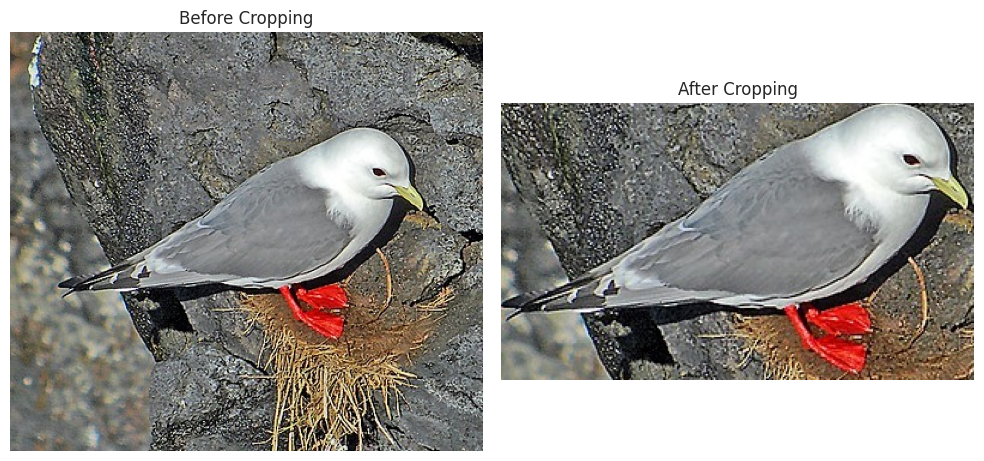

In [12]:
# === 0. Set global seed for reproducibility ===
SEED = 100
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
print(f"Using fixed seed = {SEED}")

# === 1. Load bounding boxes + image paths ===
bbox_df = pd.read_csv(bbox_file, sep=" ", header=None,
                      names=["img_id", "x", "y", "width", "height"])
images_df = pd.read_csv(images_file, sep=" ", header=None,
                        names=["img_id", "rel_path"])
df = pd.merge(bbox_df, images_df, on="img_id")

# === 2. Pick one random image (deterministic due to fixed seed) ===
row = df.sample(1, random_state=SEED).iloc[0]

# === 3. Paths and bounding box ===
img_path = os.path.join(images_dir, row["rel_path"])
x, y, w, h = int(row["x"]), int(row["y"]), int(row["width"]), int(row["height"])

# === 4. Open original and cropped image ===
img = Image.open(img_path)
cropped = img.crop((x, y, x + w, y + h))

# === 5. Show side-by-side comparison ===
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].set_title("Before Cropping", fontsize=12)
axes[0].axis("off")

axes[1].imshow(cropped)
axes[1].set_title("After Cropping", fontsize=12)
axes[1].axis("off")

plt.tight_layout()
plt.show()

### Split Cropped Dataset into Train/Test Folders

The CUB-200-2011 dataset contains 11,788 images of 200 bird species and follows an official train-test split defined in the provided `train_test_split.txt` file. Each image is annotated as either belonging to the training or testing set, and this split is fixed to ensure consistency across studies using the dataset. Following the official configuration, the cropped images are organized into two separate directories: train_cropped and test_cropped. No additional manual splitting was performed, as keeping the predefined split is essential for fair comparison with existing approaches and for reproducibility of results.

In [13]:
split_file = os.path.join(base_dir, "train_test_split.txt")
split_df = pd.read_csv(split_file, sep=" ", header=None, names=["img_id", "is_train"])
df = pd.merge(split_df, images_df, on="img_id")

# Final dataset paths
datasets_root = crop_dir
train_dir = os.path.join(datasets_root, "train_cropped")
test_dir = os.path.join(datasets_root, "test_cropped")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move images
for _, row in df.iterrows():
    src = os.path.join(crop_dir, row["rel_path"])
    dst_root = train_dir if row["is_train"] == 1 else test_dir
    dst = os.path.join(dst_root, row["rel_path"])
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if not os.path.exists(dst):
        shutil.move(src, dst)
    if os.path.exists(src):
        os.remove(src)
    src_parent = os.path.dirname(src)
    try:
        os.removedirs(src_parent)
    except OSError:
        # This occurs if the directory is not empty, so we skip it
        pass

print("Cropped dataset organized into:")
print(f"Train: {train_dir}")
print(f"Test:  {test_dir}")

Cropped dataset organized into:
Train: ./datasets/cub200_cropped/train_cropped
Test:  ./datasets/cub200_cropped/test_cropped


In [19]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"Using fixed seed = {SEED} for reproducibility.")

# === 1. Count images per class ===
def count_images_per_class(directory):
    return Counter([
        folder for folder in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, folder))
    ])

train_counts = {
    cls: len(os.listdir(os.path.join(train_dir, cls)))
    for cls in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, cls))
}

test_counts = {
    cls: len(os.listdir(os.path.join(test_dir, cls)))
    for cls in os.listdir(test_dir)
    if os.path.isdir(os.path.join(test_dir, cls))
}

# === 2. Compute total images per class (train + test) ===
total_counts = Counter({
    cls: train_counts.get(cls, 0) + test_counts.get(cls, 0)
    for cls in set(train_counts) | set(test_counts)
})

# === 3. Select top 10 classes (sorted for consistency) ===
top_10_classes = dict(total_counts.most_common(10))
print("\nTop 10 classes to keep (deterministic):")
for cls, total in sorted(top_10_classes.items(), key=lambda x: x[0]):
    print(f"  {cls}: train={train_counts.get(cls, 0)}, test={test_counts.get(cls, 0)}, total={total}")

# === 4. Keep only top classes ===
def keep_only_top_classes(base_path, top_classes):
    for cls in os.listdir(base_path):
        cls_path = os.path.join(base_path, cls)
        if os.path.isdir(cls_path) and cls not in top_classes:
            shutil.rmtree(cls_path)

keep_only_top_classes(train_dir, top_10_classes)
keep_only_top_classes(test_dir, top_10_classes)

print("\nFinal dataset created:")
print(f"Train images → {train_dir}")
print(f"Test images  → {test_dir}")


Using fixed seed = 42 for reproducibility.

Top 10 classes to keep (deterministic):
  002.Laysan_Albatross: train=30, test=30, total=60
  055.Evening_Grosbeak: train=30, test=30, total=60
  061.Heermann_Gull: train=30, test=30, total=60
  094.White_breasted_Nuthatch: train=30, test=30, total=60
  099.Ovenbird: train=30, test=30, total=60
  106.Horned_Puffin: train=30, test=30, total=60
  128.Seaside_Sparrow: train=30, test=30, total=60
  130.Tree_Sparrow: train=30, test=30, total=60
  138.Tree_Swallow: train=30, test=30, total=60
  140.Summer_Tanager: train=30, test=30, total=60

Final dataset created:
Train images → ./datasets/cub200_cropped/train_cropped
Test images  → ./datasets/cub200_cropped/test_cropped


In [ ]:
!pip install Augmentor --quiet
import Augmentor
import os
def makedir(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

datasets_root_dir = './datasets/cub200_cropped/'
dir = datasets_root_dir + 'train_cropped/'
target_dir = '../../train_cropped_augmented/'

makedir('./datasets/cub200_cropped/train_cropped_augmented/')
folders = [os.path.join(dir, folder) for folder in next(os.walk(dir))[1]]
target_folders = [os.path.join(target_dir, folder) for folder in next(os.walk(dir))[1]]
for i in range(len(folders)):
    fd = folders[i]
    tfd = target_folders[i]
    # rotation
    marker_path = os.path.join(fd,tfd)

    # Skip if already augmented
    if os.path.exists(marker_path):
        print(f"Skipping {fd} -> {tfd} (augmentation already done)")
        continue

    print(f"Augmenting: {fd} -> {tfd}")
    p = Augmentor.Pipeline(source_directory=fd, output_directory=tfd)
    p.rotate(probability=1, max_left_rotation=15, max_right_rotation=15)
    p.flip_left_right(probability=0.5)
    for i in range(10):
        p.process()
    del p
    # skew
    p = Augmentor.Pipeline(source_directory=fd, output_directory=tfd)
    p.skew(probability=1, magnitude=0.2)  # max 45 degrees
    p.flip_left_right(probability=0.5)
    for i in range(10):
        p.process()
    del p
    # shear
    p = Augmentor.Pipeline(source_directory=fd, output_directory=tfd)
    p.shear(probability=1, max_shear_left=10, max_shear_right=10)
    p.flip_left_right(probability=0.5)
    for i in range(10):
        p.process()
    del p

Using fixed seed = 42


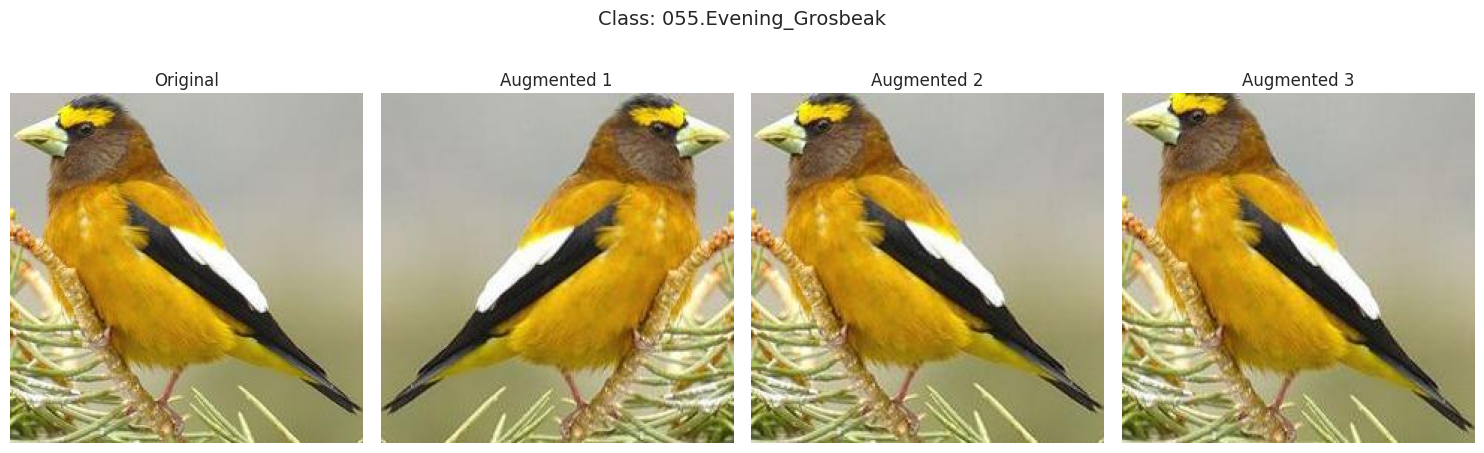

Class: 055.Evening_Grosbeak
Original image: Evening_Grosbeak_0104_37661.jpg
Augmented samples: ['055.Evening_Grosbeak_original_Evening_Grosbeak_0104_37661.jpg_0679f38f-9148-43cf-9cec-0c2105f3e332.jpg', '055.Evening_Grosbeak_original_Evening_Grosbeak_0104_37661.jpg_080f8a58-e349-4235-a933-27a5d5f14594.jpg', '055.Evening_Grosbeak_original_Evening_Grosbeak_0104_37661.jpg_13eb6733-e5d9-4d67-acad-0c85dab9e244.jpg']


In [22]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Using fixed seed = {SEED}")

# === 1. Paths ===
train_dir = "./datasets/cub200_cropped/train_cropped/"
aug_dir = "./datasets/cub200_cropped/train_cropped_augmented/"

# === 2. Pick a fixed random class ===
classes = sorted(os.listdir(train_dir))
cls = random.choice(classes)

# === 3. Pick a fixed random original image ===
orig_images = [f for f in os.listdir(os.path.join(train_dir, cls)) 
               if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
orig_img_name = random.choice(orig_images)
orig_img_path = os.path.join(train_dir, cls, orig_img_name)

# === 4. Get augmented images for the same original ===
# Only pick augmentations that correspond to the same original image name
aug_images = [
    f for f in os.listdir(os.path.join(aug_dir, cls)) 
    if f.lower().endswith(('.jpg', '.png', '.jpeg')) 
    and orig_img_name.split('.')[0] in f  # match original image name prefix
]

# Sample up to 3 augmentations deterministically
sample_aug_imgs = sorted(aug_images)[:3]  # deterministic selection

# === 5. Show original + its augmentations ===
fig, axes = plt.subplots(1, len(sample_aug_imgs) + 1, figsize=(15, 5))

# Original image
axes[0].imshow(Image.open(orig_img_path))
axes[0].axis("off")
axes[0].set_title("Original")

# Augmented images
for i, aug_img in enumerate(sample_aug_imgs, start=1):
    aug_img_path = os.path.join(aug_dir, cls, aug_img)
    axes[i].imshow(Image.open(aug_img_path))
    axes[i].axis("off")
    axes[i].set_title(f"Augmented {i}")

plt.suptitle(f"Class: {cls}", fontsize=14)
plt.tight_layout()
plt.show()

print(f"Class: {cls}")
print(f"Original image: {orig_img_name}")
print(f"Augmented samples: {sample_aug_imgs}")

## **Exploratory Data Analysis**

The dataset uses an almost balanced split, with 5,994 images in the training set and 5,794 images in the testing set, which corresponds roughly to a 50/50 ratio. Unlike many modern datasets that favor an 80/20 or 70/30 split, CUB-200-2011 was designed for fine-grained classification, where evaluation should be equally challenging. On average, each class has around 30 training and 30 testing images, although minor variations exist due to differences in the total number of available images per species. For example, some classes, such as Crested Auklet, contain only 14 test images, while others are perfectly balanced. This balanced design ensures that the model’s performance is tested under more challenging conditions, with limited data per class and an equally large evaluation set.

### Dataset Overview & Image Counts

In [24]:
def count_images_per_class(directory):
    """Count number of images in each class folder."""
    counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Count images per class
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

print("=== Dataset Overview ===")
print(f" • Total classes          : {len(train_counts)}")
print(f" • Total training images  : {sum(train_counts.values())}")
print(f" • Total testing images   : {sum(test_counts.values())}")

# Show a few example classes
print("\n=== Example Class Distribution ===")
for i, (cls, count) in enumerate(list(train_counts.items())[:5]):
    print(f" • {cls}: {count} training images, {test_counts.get(cls, 0)} testing images")

=== Dataset Overview ===
 • Total classes          : 10
 • Total training images  : 300
 • Total testing images   : 300

=== Example Class Distribution ===
 • 002.Laysan_Albatross: 30 training images, 30 testing images
 • 055.Evening_Grosbeak: 30 training images, 30 testing images
 • 061.Heermann_Gull: 30 training images, 30 testing images
 • 094.White_breasted_Nuthatch: 30 training images, 30 testing images
 • 099.Ovenbird: 30 training images, 30 testing images


### Check for Missing Classes in Train/Test Splits

In [25]:
missing_in_test = set(train_counts.keys()) - set(test_counts.keys())
missing_in_train = set(test_counts.keys()) - set(train_counts.keys())

if missing_in_test:
    print(f"Classes missing in test set: {len(missing_in_test)}")
else:
    print("No classes are missing in the test set.")

if missing_in_train:
    print(f"Classes missing in train set: {len(missing_in_train)}")
else:
    print("No classes are missing in the train set.")

No classes are missing in the test set.
No classes are missing in the train set.


In [26]:
# Convert counts into DataFrames
train_df = pd.DataFrame.from_dict(train_counts, orient="index", columns=["train_images"])
test_df = pd.DataFrame.from_dict(test_counts, orient="index", columns=["test_images"])

# Merge them into one table
counts_df = train_df.join(test_df, how="outer").fillna(0).astype(int)
counts_df["total_images"] = counts_df["train_images"] + counts_df["test_images"]

print("\n=== Combined Class Counts ===")
print(counts_df.head())


=== Combined Class Counts ===
                             train_images  test_images  total_images
002.Laysan_Albatross                   30           30            60
055.Evening_Grosbeak                   30           30            60
061.Heermann_Gull                      30           30            60
094.White_breasted_Nuthatch            30           30            60
099.Ovenbird                           30           30            60


In [27]:
def check_corrupted_images(root_dir):
    corrupted_files = []
    total_images = 0

    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            total_images += 1
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity without fully loading
            except Exception:
                corrupted_files.append(img_path)

    return corrupted_files, total_images


# Check train set
corrupted_train, total_train = check_corrupted_images(train_dir)
print(f"Train set: {total_train} images scanned.")
print(f"Corrupted or unreadable images in train set: {len(corrupted_train)}")
if corrupted_train:
    print("\nExample corrupted train images:")
    print("\n".join(corrupted_train[:5]))

# Check test set
corrupted_test, total_test = check_corrupted_images(test_dir)
print(f"\nTest set: {total_test} images scanned.")
print(f"Corrupted or unreadable images in test set: {len(corrupted_test)}")
if corrupted_test:
    print("\nExample corrupted test images:")
    print("\n".join(corrupted_test[:5]))

Train set: 300 images scanned.
Corrupted or unreadable images in train set: 0

Test set: 300 images scanned.
Corrupted or unreadable images in test set: 0


### Visualize Class Distribution

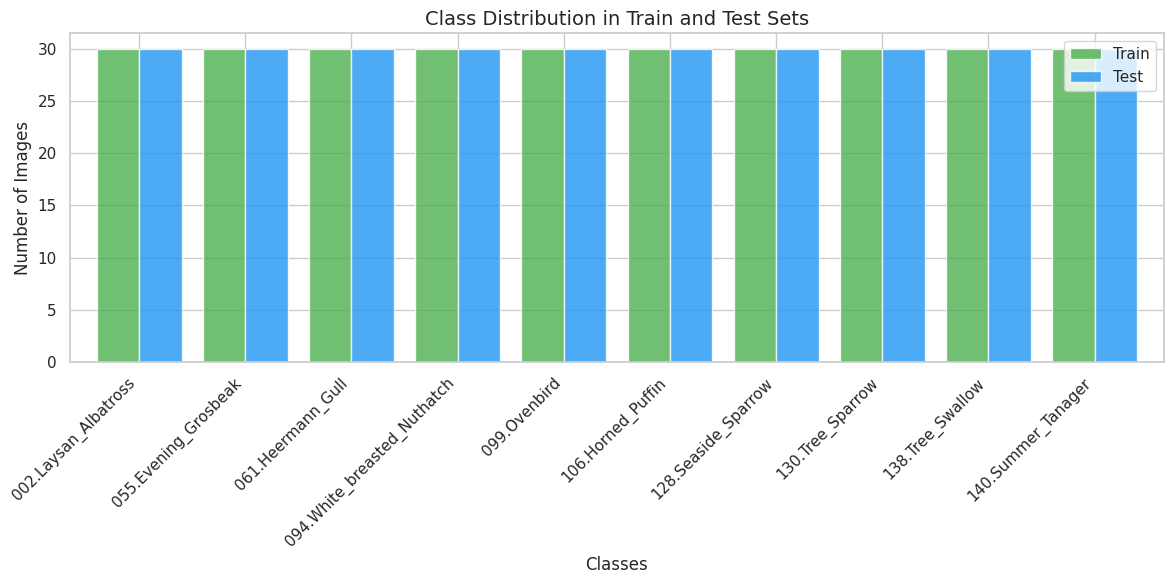

In [28]:
# Plot class distribution for the remaining 10 classes
ax = counts_df[["train_images", "test_images"]].plot(
    kind="bar",
    figsize=(12, 6),
    color=["#4CAF50", "#2196F3"],
    alpha=0.8,
    width=0.8
)

# Title and labels
plt.title("Class Distribution in Train and Test Sets", fontsize=14)
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.xticks(rotation=45, ha="right")

# Add legend
plt.legend(["Train", "Test"])

# Optimize layout
plt.tight_layout()
plt.show()

### Analyze image dimensions (width & height)

In [29]:
def get_image_sizes(root_dir, num_samples=300):
    """Randomly sample images and record their dimensions."""
    sizes = []
    all_images = []

    # Collect all image paths
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                all_images.append(os.path.join(class_path, img_file))

    # Random sampling
    sample_images = random.sample(all_images, min(len(all_images), num_samples))

    # Record image sizes
    for img_path in sample_images:
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)  # (width, height)
        except:
            # Skip unreadable or corrupted images
            continue

    return pd.DataFrame(sizes, columns=["width", "height"])

# Run the function on your train directory
image_sizes_df = get_image_sizes(train_dir, num_samples=2000)

In [30]:
# Basic descriptive statistics
print("=== Image Dimensions Summary ===")
print(image_sizes_df.describe().to_string())

=== Image Dimensions Summary ===
            width      height
count  300.000000  300.000000
mean   263.526667  242.490000
std     83.937961   74.333178
min    101.000000  106.000000
25%    202.000000  190.750000
50%    258.000000  236.500000
75%    319.000000  284.250000
max    476.000000  491.000000


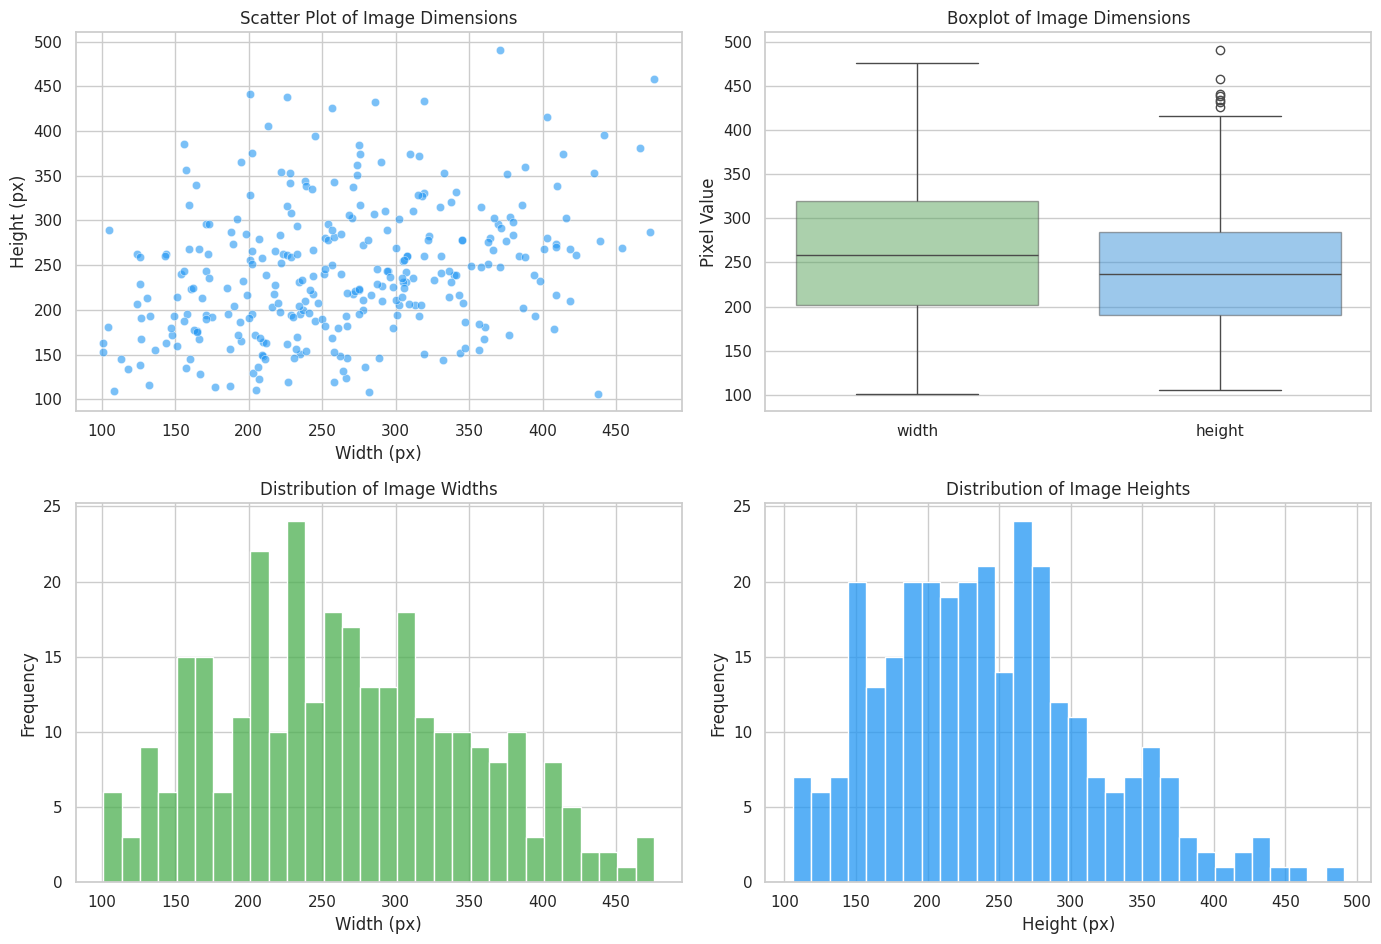

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scatter plot: width vs height (top-left)
sns.scatterplot(
    data=image_sizes_df, x="width", y="height",
    alpha=0.6, color="#2196F3", ax=axes[0, 0]
)
axes[0, 0].set_title("Scatter Plot of Image Dimensions")
axes[0, 0].set_xlabel("Width (px)")
axes[0, 0].set_ylabel("Height (px)")

# 2. Boxplot for outliers (top-right) with transparency
sns.boxplot(
    data=image_sizes_df[["width", "height"]],
    palette=["#4CAF50", "#2196F3"],
    ax=axes[0, 1],
    boxprops=dict(alpha=0.5)   # transparency for boxes
)
axes[0, 1].set_title("Boxplot of Image Dimensions")
axes[0, 1].set_ylabel("Pixel Value")

# 3. Histogram of widths (bottom-left)
sns.histplot(
    image_sizes_df["width"], bins=30,
    color="#4CAF50", ax=axes[1, 0]
)
axes[1, 0].set_title("Distribution of Image Widths")
axes[1, 0].set_xlabel("Width (px)")
axes[1, 0].set_ylabel("Frequency")

# 4. Histogram of heights (bottom-right)
sns.histplot(
    image_sizes_df["height"], bins=30,
    color="#2196F3", ax=axes[1, 1]
)
axes[1, 1].set_title("Distribution of Image Heights")
axes[1, 1].set_xlabel("Height (px)")
axes[1, 1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Display random sample images from random classes

Using fixed seed = 35


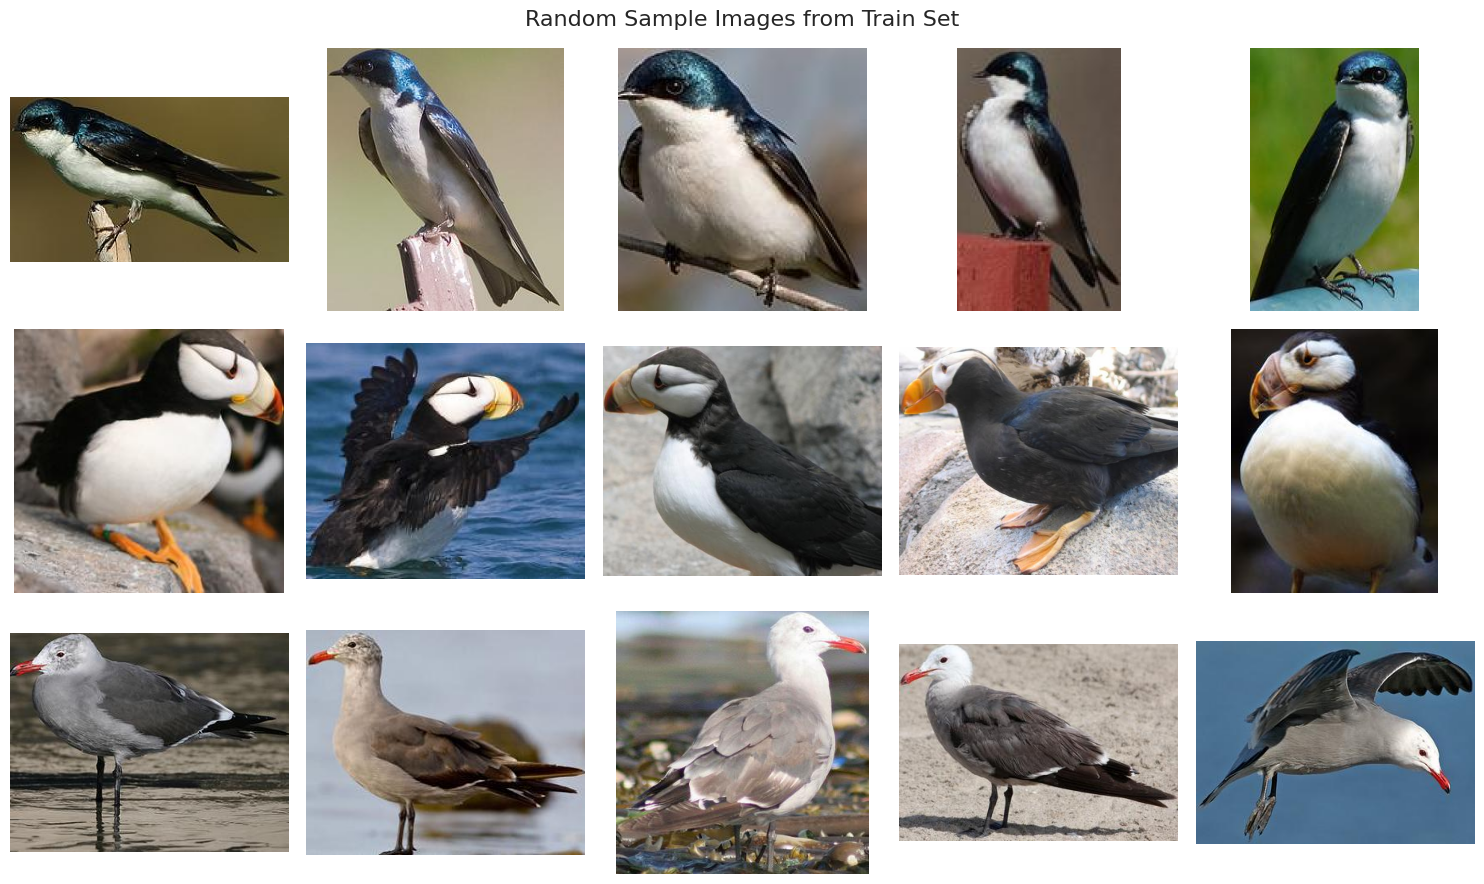

In [32]:
SEED = 35
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Using fixed seed = {SEED}")

# === 1. Function to show random images ===
def show_random_images(root_dir, num_classes=3, num_images=5):
    """Display a grid of random images from random classes with reproducibility."""
    # Pick random classes (deterministic due to seed)
    class_names = random.sample(sorted(os.listdir(root_dir)), num_classes)
    plt.figure(figsize=(num_images * 3, num_classes * 3))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(root_dir, class_name)
        image_files = sorted([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        # Pick random images for each class (deterministic due to seed)
        images = random.sample(image_files, min(len(image_files), num_images))

        for j, img_file in enumerate(images):
            img_path = os.path.join(class_path, img_file)

            # Open and display image
            img = Image.open(img_path)
            plt.subplot(num_classes, num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.axis("off")

            # Label class name on the left of the row
            if j == 0:
                plt.ylabel(class_name, fontsize=12, rotation=0, labelpad=40)

    plt.suptitle("Random Sample Images from Train Set", fontsize=16)
    plt.tight_layout()
    plt.show()

# === 2. Show 3 random classes with 5 random images each ===
show_random_images(train_dir, num_classes=3, num_images=5)


# Baseline Model

In [33]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [39]:
# Dataset paths
train_dir = "./datasets/cub200_cropped/train_cropped_augmented"
test_dir = "./datasets/cub200_cropped/test_cropped"

# Image transforms (matching pretrained ResNet input)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [41]:
# Load train and test datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train size: 8309, Test size: 300
Classes: ['002.Laysan_Albatross', '055.Evening_Grosbeak', '061.Heermann_Gull', '094.White_breasted_Nuthatch', '099.Ovenbird', '106.Horned_Puffin', '128.Seaside_Sparrow', '130.Tree_Sparrow', '138.Tree_Swallow', '140.Summer_Tanager']


In [42]:
# Load pretrained ResNet50
resnet = models.vgg19(pretrained=True)
resnet.eval()  # freeze model

# Remove the classification head — keep only feature extractor
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor = feature_extractor.to("cuda" if torch.cuda.is_available() else "cpu")

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
def extract_features(dataloader):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = feature_extractor(images)       # shape: (batch, 2048, 1, 1)
            features = features.view(features.size(0), -1)  # flatten to (batch, 2048)

            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())

    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract embeddings
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

print("Feature shape:", train_features.shape)

Feature shape: (8309, 25088)


In [45]:
clf = LogisticRegression(max_iter=500, solver="lbfgs", multi_class="multinomial")
clf.fit(train_features, train_labels)

# Predict on test set
y_pred = clf.predict(test_features)

# Evaluate
print("Accuracy:", accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred, target_names=train_dataset.classes))

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.95
                             precision    recall  f1-score   support

       002.Laysan_Albatross       1.00      0.90      0.95        30
       055.Evening_Grosbeak       1.00      1.00      1.00        30
          061.Heermann_Gull       0.94      1.00      0.97        30
094.White_breasted_Nuthatch       0.88      0.97      0.92        30
               099.Ovenbird       0.93      0.93      0.93        30
          106.Horned_Puffin       1.00      0.97      0.98        30
        128.Seaside_Sparrow       0.88      0.93      0.90        30
           130.Tree_Sparrow       0.96      0.90      0.93        30
           138.Tree_Swallow       0.93      0.90      0.92        30
         140.Summer_Tanager       1.00      1.00      1.00        30

                   accuracy                           0.95       300
                  macro avg       0.95      0.95      0.95       300
               weighted avg       0.95      0.95      0.95       300



# ProtoPNet

In [48]:
!python3 main.py

0
training set size: 8309
push set size: 300
test set size: 300
batch size: 40
start training
epoch: 	0
	warm
	train
	time: 	9.740630149841309
	cross ent: 	1.5339287118269846
	cluster: 	1.8325500902003393
	separation:	1.736778563246704
	avg separation:	10.247512927422157
	accu: 		56.119870020459736%
	l1: 		550.0
	p dist pair: 	19.50064468383789
	test
	time: 	0.4852597713470459
	cross ent: 	1.289079596598943
	cluster: 	0.2665833756327629
	separation:	0.2536545768380165
	avg separation:	9.484561125437418
	accu: 		60.66666666666667%
	l1: 		550.0
	p dist pair: 	19.50064468383789
epoch: 	1
	warm
	train
	time: 	9.46129822731018
	cross ent: 	0.502119595471483
	cluster: 	0.09379648170075737
	separation:	0.2456214871400824
	avg separation:	9.37400496006012
	accu: 		87.25478396919003%
	l1: 		550.0
	p dist pair: 	18.880815505981445
	test
	time: 	0.4884641170501709
	cross ent: 	0.8205377409855524
	cluster: 	0.1269151009619236
	separation:	0.1976837913195292
	avg separation:	8.992686907450357
	accu

...

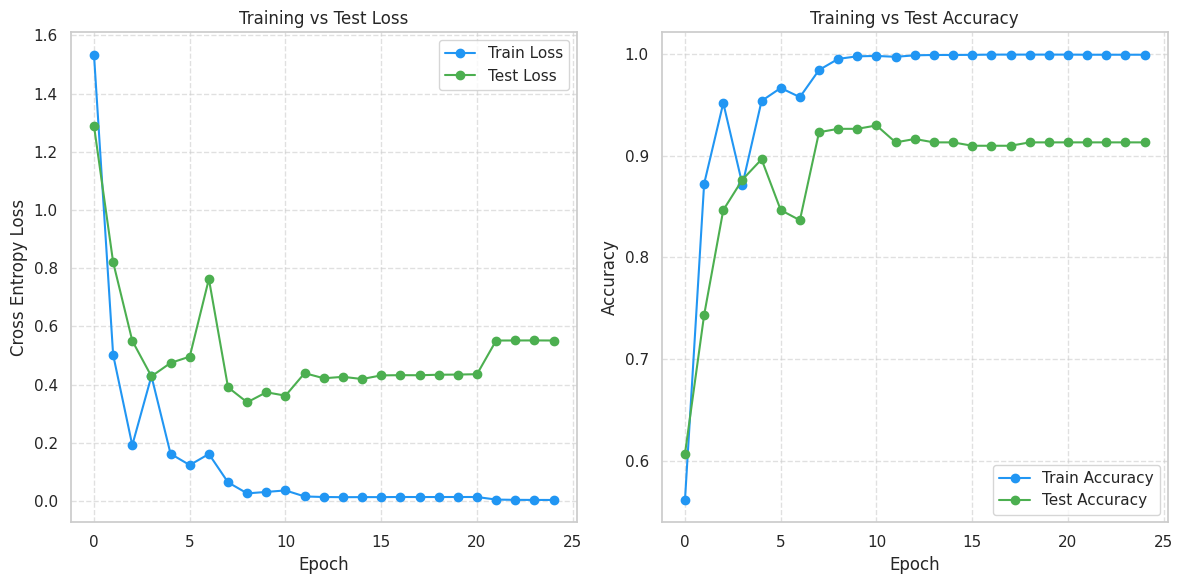

In [4]:
import re
import matplotlib.pyplot as plt

# Path to your training log file
log_file = "./results.txt"  # <-- replace with your log file path

# Containers for metrics
epochs = []
train_loss = []
test_loss = []
train_accu = []
test_accu = []

# Read the log file
with open(log_file, "r") as f:
    log_text = f.read()

# Split the log into blocks per epoch
epoch_blocks = re.split(r"epoch:", log_text)[1:]

for block in epoch_blocks:
    # Extract epoch number
    epoch_num_match = re.match(r"\s*(\d+)", block)
    if epoch_num_match:
        epochs.append(int(epoch_num_match.group(1)))

    # === TRAIN LOSS ===
    train_cross_ent = re.search(r"train.*?cross ent:\s+([\d\.]+)", block, re.S)
    if train_cross_ent:
        train_loss.append(float(train_cross_ent.group(1)))
    else:
        train_loss.append(None)

    # === TRAIN ACCURACY ===
    train_acc_match = re.search(r"train.*?accu:\s+([\d\.]+)", block, re.S)
    if train_acc_match:
        acc = float(train_acc_match.group(1))
        if acc > 1:  # Convert percentage if needed
            acc /= 100.0
        train_accu.append(acc)
    else:
        train_accu.append(None)

    # === TEST LOSS ===
    test_cross_ent = re.search(r"test.*?cross ent:\s+([\d\.]+)", block, re.S)
    if test_cross_ent:
        test_loss.append(float(test_cross_ent.group(1)))
    else:
        test_loss.append(None)

    # === TEST ACCURACY ===
    test_acc_match = re.search(r"test.*?accu:\s+([\d\.]+)", block, re.S)
    if test_acc_match:
        acc = float(test_acc_match.group(1))
        if acc > 1:
            acc /= 100.0
        test_accu.append(acc)
    else:
        test_accu.append(None)

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", marker="o", color="#2196F3")
plt.plot(epochs, test_loss, label="Test Loss", marker="o", color="#4CAF50")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.6)

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accu, label="Train Accuracy", marker="o", color="#2196F3")
plt.plot(epochs, test_accu, label="Test Accuracy", marker="o", color="#4CAF50")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [50]:
!python3 global_analysis.py \
    -modeldir saved_models/vgg19/003/ \
    -model 20push0.9133.pth

load model from saved_models/vgg19/003/20push0.9133.pth
find nearest patches
batch 0
batch 1
batch 2
	find nearest patches time: 	47.745023012161255
find nearest patches
batch 0
batch 1
batch 2
	find nearest patches time: 	41.49751424789429


In [6]:
!python3 local_analysis.py -modeldir='./saved_models/vgg19/003/' -model='20push0.9133.pth' -imgdir './local_analysis/' -img 'Laysan_Albatross_0001_545.jpg' -imgclass 0

load model from ./saved_models/vgg19/003/20push0.9133.pth
model base architecture: vgg19
experiment run: 003/
Prototypes are chosen from 10 number of classes.
Their class identities are: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]
All prototypes connect most strongly to their respective classes.
0 (0, 0)
Predicted: 0
Actual: 0
image index 0 in batch
Most activated 10 prototypes of this image:
top 1 activated prototype for this image:
prototype index: 9
prototype class identity: 0
activation value (similarity score): 1.367122769355774
last layer connection with predicted class: 1.1426408290863037
most highly activated patch of the chosen image by this prototype:
most highly activated patch by this prototype shown in the original image:
prototype activation map of the chosen image:
-------------------------------------------------